In [1]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("iGMRF.jl");
include("dataGen.jl");
include("gibbs.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [2]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂
# Insuffisance de rang de la matrice de structure
r = 1;
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);

In [3]:
grid_target = generateTargetGrid(F);

In [4]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 0.0211641   0.0153844   -0.117718
 0.077531    0.00983722  -0.0508229
 0.0955774  -0.0244998   -0.0264531

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [5]:
nobs = 1000
data = generateData(grid_target, nobs);

# Modèle 

In [7]:
include("gibbs.jl");

niter = 10000
δ² = 0.07
κᵤ₀ = 10
μ₀ = zeros(m)

κᵤ, μ = gibbs(niter, data, m₁=m₁, m₂=m₂, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀);

θ = vcat(reshape(κᵤ, 1, niter), μ)

μ = θ[2:end, :];
κᵤ = θ[1, :];

μ̂ = mean(θ[2:end, :], dims=2);
κ̂ᵤ = mean(θ[1, :]);

Taux d'acceptation μ1: 41.19 %
Taux d'acceptation μ2: 38.98 %
Taux d'acceptation μ3: 40.34 %
Taux d'acceptation μ4: 39.58 %
Taux d'acceptation μ5: 37.0 %
Taux d'acceptation μ6: 39.31 %
Taux d'acceptation μ7: 40.67 %
Taux d'acceptation μ8: 39.43 %
Taux d'acceptation μ9: 41.09 %


In [8]:
reshape(μ[:, end], m₁, m₂)

3×3 Matrix{Float64}:
  0.0170526   0.0545001  -0.0108397
 -0.0339602   0.0291929  -0.0353613
 -0.0947807  -0.0680058  -0.0405023

In [9]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 0.0211641   0.0153844   -0.117718
 0.077531    0.00983722  -0.0508229
 0.0955774  -0.0244998   -0.0264531

Distance entre les deux matrices

In [10]:
norm(reshape(μ[:, end], m₁, m₂) .- grid_target[:, :, 1], 2) / m

0.02818377449637086

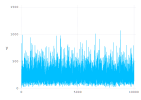

In [11]:
plot(y=κᵤ, Geom.line)

In [12]:
mean(κᵤ)

239.28609787671604

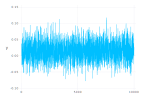

In [13]:
plot(y=μ[1, :], Geom.line)

In [14]:
using Mamba

sim = Chains(
    copy(θ'), 
    names=["κᵤ", "μ1", "μ2", "μ3", "μ4", "μ5", "μ6", "μ7", "μ8", "μ9"]
);

summarystats(sim)

        Mean            SD         Naive SE        MCSE        ESS   
κᵤ 239.2860978767 124.522007037 1.24522007037 2.04029018695 3724.8462
μ1   0.0150481086   0.027176903 0.00027176903 0.00061677354 1941.5495
μ2  -0.0184477375   0.025761977 0.00025761977 0.00064458339 1597.3503
μ3  -0.0861613034   0.026482555 0.00026482555 0.00060657800 1906.1035
μ4   0.0533720208   0.026197484 0.00026197484 0.00057463083 2078.4584
μ5  -0.0005533918   0.024204106 0.00024204106 0.00055715320 1887.2475
μ6  -0.0487369432   0.025981849 0.00025981849 0.00055308392 2206.7749
μ7   0.0403444917   0.027599644 0.00027599644 0.00058175448 2250.7512
μ8  -0.0219363765   0.025928655 0.00025928655 0.00055211970 2205.4310
μ9  -0.0544326739   0.026903450 0.00026903450 0.00056798149 2243.6111

